# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 6 - RNNs



**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print(tf.keras.__version__)
print(tf.__version__)

2.2.4-tf
2.0.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.random.set_seed(456)

<div class="theme"> Part 1: Data </div>
Read `HW6_data.csv` into a pandas dataframe using the provided code below.

In [5]:
# Given code
path_dataset = './data/HW6_data.csv'
data = pd.read_csv(path_dataset,
                   encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity


<div class='exercise'><b> Question 1: Data [20 points total]</b></div>

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 
**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`
 
**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

**1.12** Split the dataset into train and test sets (test 10%).

## Answers

**1.1** Create a list of unique words found in the 'Word' column and sort it in alphabetic order. Then append the special word "ENDPAD" to the end of the list, and assign it to the variable ```words```. Store the length of this list as ```n_words```. **Print your results for `n_words`**

In [6]:
# your code here
words=sorted(data.Word.unique())
words.append('ENDPAD')

n_words=len(words)

print(n_words)
print(words[-1])

35179
ENDPAD


In [7]:
# Run this cell to show your results for n_words
print(n_words)

35179


**1.2** Create a list of unique tags and sort it in alphabetic order. Then append the special word "PAD" to the end of the list, and assign it to the variable ```tags```. Store the length of this list as ```n_tags```. **Print your results for `n_tags`**

In [8]:
# your code here
tags=sorted(data.Tag.unique())
tags.append("PAD")
n_tags=len(tags)

In [9]:
# Run this cell to show your results for n_tags
print(n_tags)
print(tags[-1])

18
PAD


**1.3** Process the data into a list of sentences where each sentence is a list of (word, tag) tuples. Here is an example of how the first sentence in the list should look:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
 

In [10]:
data['Sentence #'].unique()

array(['Sentence: 1', 'Sentence: 2', 'Sentence: 3', ...,
       'Sentence: 47957', 'Sentence: 47958', 'Sentence: 47959'],
      dtype=object)

In [11]:
# your code here
# root='Sentence: '

# sentences=[list(zip(data[data['Sentence #']==(root + str(i))].Word, data[data['Sentence #']==(root + str(i))].Tag))\
#            for i in range(1, 47958+1)]

# using for loop to proceess a dataframe is taking forever
w = data.groupby(['Sentence #']).Word.apply(list).to_list()
t = data.groupby("Sentence #").Tag.apply(list).to_list()
sentences = [list(zip(w[i],t[i])) for i in range(len(w))]


In [12]:
sentences[0]

[('Thousands', 'O'),
 ('of', 'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]

In [13]:
len(sentences)

47959

**1.4** Find out the number of words in the longest sentence, and store it to variable ```max_len```. **Print your results for `max_len`.**

In [14]:
# your code here
lens= [len(i) for i in sentences]
max_len = max(lens)

In [15]:
# Run this cell to show your results for max_len
print(max_len)

104


**1.5** It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary.

In [16]:
# your code here
word2idx=dict(zip(words, range(n_words)))
idx2word=dict(zip(range(n_words), words))

In [17]:
word2idx['1,700'], idx2word[156]

(156, '1,700')

In [18]:
idx2word

{0: '!',
 1: '"',
 2: '#',
 3: '#NAME?',
 4: '$',
 5: '%',
 6: '%-plus',
 7: '&',
 8: "'",
 9: "'70s",
 10: "'80s",
 11: "'T",
 12: "'d",
 13: "'ll",
 14: "'m",
 15: "'n",
 16: "'re",
 17: "'s",
 18: "'ve",
 19: '(',
 20: ')',
 21: ',',
 22: '-',
 23: '--',
 24: '.',
 25: '..',
 26: '...',
 27: '.tv',
 28: '/',
 29: '0',
 30: '0-3',
 31: '0-6',
 32: '0.01',
 33: '0.02',
 34: '0.04',
 35: '0.050474537',
 36: '0.051655093',
 37: '0.060092593',
 38: '0.068171296',
 39: '0.068217593',
 40: '0.068263889',
 41: '0.068275463',
 42: '0.068472222',
 43: '0.08',
 44: '0.1',
 45: '0.110474537',
 46: '0.110625',
 47: '0.12',
 48: '0.161',
 49: '0.17',
 50: '0.19',
 51: '0.193',
 52: '0.2',
 53: '0.3',
 54: '0.35',
 55: '0.4',
 56: '0.5',
 57: '0.55',
 58: '0.6',
 59: '0.65',
 60: '0.7',
 61: '0.8',
 62: '0.82',
 63: '0.9',
 64: '01-Feb',
 65: '01-Jan',
 66: '01-Jun',
 67: '02-Feb',
 68: '02-Jan',
 69: '02-Jun',
 70: '02-May',
 71: '03-Apr',
 72: '03-Feb',
 73: '03-Jan',
 74: '03-Jun',
 75: '03-Mar

**1.6** Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 

In [19]:
# your code here
X=[]
for s in sentences:
    temp=[]
    for w in s:
        temp.append(word2idx[w[0]])
    X.append(temp)
print(len(X))

47959


**1.7** Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```. Run the provided cell to print your results. Your ```X[i]``` now should be something similar to this:

`[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]`

In [20]:
# your code here
X=pad_sequences(X, maxlen=max_len, padding='post', value=35178)

In [21]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


**1.8** Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

In [22]:
# your code here
tag2idx=dict(zip(tags, range(n_tags)))
idx2tag=dict(zip(range(n_tags), tags))

In [23]:
idx2tag[17]

'PAD'

**1.9** Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.

In [24]:
# your code here
Y=[]
for s in sentences:
    temp=[]
    for w in s:
        temp.append(tag2idx[w[1]])  # w: (word, tag) form 
    Y.append(temp)
print(Y[0])
print(len(Y))

[16, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16, 2, 16, 16, 16, 16, 16, 3, 16, 16, 16, 16, 16]
47959


**1.10** apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

In [25]:
tag2idx['PAD']

17

In [26]:
# your code here
# from Keras: Sequences that are shorter than num_timesteps are padded with value at the end.
Y=pad_sequences(Y, maxlen=max_len, padding='post', value=17)
print(Y.shape)

(47959, 104)


In [27]:
Y[0][0]

16

**1.11** Use the ```to_categorical``` keras function to one-hot encode the tags. Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```. Run the provided cell to print your results.

In [28]:
# your code here
Y=to_categorical(Y, num_classes=n_tags)
print(Y.shape)

(47959, 104, 18)


In [29]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(Y[0][-1]))
print(np.array(Y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


**1.12** Split the dataset into train and test sets (test 10%).

In [30]:
# your code here
split_at = len(X) - len(X) // 10
x_train, x_test, y_train, y_test = X[:split_at], X[split_at:],Y[:split_at],Y[split_at:]

## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [31]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [32]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = tf.keras.models.model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40 points total]</b></div>

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


**2.2a** Explain what the embedding layer is and why we need it here.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

## Answers

**2.1** **Model 1: Baseline Model**

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])


In [33]:
# your code here
x_train.shape,y_train.shape

((43164, 104), (43164, 104, 18))

In [34]:
freq={key:np.zeros(18) for key in idx2word}
len(freq), len(freq[0])

(35179, 18)

In [35]:
for i in range(len(x_train)):
    for j in range(len(s)):
        t=np.array(y_train[i][j]) # get the idx of the tag
        freq[x_train[i][j]]+= t # np array sum
freq

{0: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0., 24.,  0.]),
 1: array([0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 9.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 0.000e+00,
        0.000e+00, 2.500e+01, 2.100e+01, 4.000e+00, 3.078e+03, 0.000e+00]),
 2: array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 10.,  0.]),
 3: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.]),
 4: array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 991.,   0.]),
 5: array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 352.,   0.]),
 6: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0.]),
 7: array([ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        24.,  0.,  0.,  0.,  0.

In [36]:
baseline=[]
for k in range(max(freq.keys())+1): 
    # here don't break if it reaches 35178, because the 'PAD' NEED TO BE TAGGED, OTHERWISE 0 IS FIILED IN
    temp = freq[k].argmax()
    baseline.append(temp)

baseline=np.array(baseline)

In [37]:
idx2word[35178],

('ENDPAD',)

In [38]:
# Run this cell to show your results #
print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

**2.2** **Model 2: Vanilla Feed Forward Neural Network**

This model is provided for you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.


### Use these hyperparameters for all NN models

In [39]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

In [40]:
# Define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [41]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 50)           1758950   
_________________________________________________________________
dropout (Dropout)            (None, 104, 50)           0         
_________________________________________________________________
dense (Dense)                (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [82]:
# Train model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 15s 393us/sample - loss: 0.3149 - accuracy: 0.9787 - val_loss: 0.0611 - val_accuracy: 0.9855
Epoch 2/10
38847/38847 [==============================] - 13s 336us/sample - loss: 0.0513 - accuracy: 0.9863 - val_loss: 0.0496 - val_accuracy: 0.9865
Epoch 3/10
38847/38847 [==============================] - 13s 334us/sample - loss: 0.0449 - accuracy: 0.9873 - val_loss: 0.0469 - val_accuracy: 0.9871
Epoch 4/10
38847/38847 [==============================] - 13s 332us/sample - loss: 0.0426 - accuracy: 0.9878 - val_loss: 0.0456 - val_accuracy: 0.9874
Epoch 5/10
38847/38847 [==============================] - 13s 340us/sample - loss: 0.0413 - accuracy: 0.9882 - val_loss: 0.0449 - val_accuracy: 0.9875
Epoch 6/10
38847/38847 [==============================] - 13s 335us/sample - loss: 0.0404 - accuracy: 0.9884 - val_loss: 0.0444 - val_accuracy: 0.9877
Epoch 7/10
38847/38847 [=====================

In [83]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


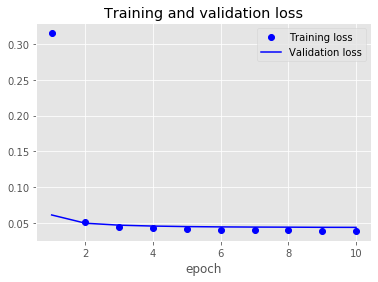

In [84]:
plot_training_history(history)

**2.2a** Explain what the embedding layer is and why we need it here.

*your answer here*

Embedding layer transforms the words into representations with their meanings. Compared to one-hot encoding, the vectors for each word now shows similarity based on words' syntatic similarity which reflects word meanings.

**2.2b** Explain why the Param # of Embedding layer is 1758950 (as shown in `print(model.summary())`).

In [249]:
n_words*dim_embed

1758950

*your answer here*

The param # is a product of n_words*embed_dim. It returns a matrix with each row representing a word and the row vector stands for the embedding of this word.

### Viewing Hidden Layers
In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that this code and the parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [42]:
FFNN = load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(x_test)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9396784632326867


In [43]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

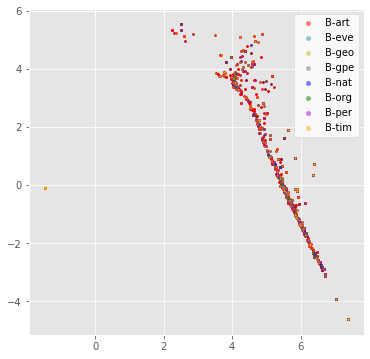

In [44]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [45]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = tf.keras.backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [46]:
def visualize_B_I(pca_result):
    color = ['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_test.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices = np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend = ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.939679112059921


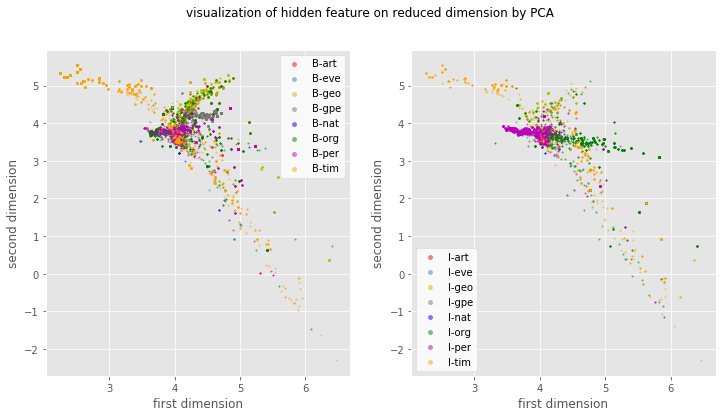

In [95]:
h = get_hidden_output_PCA(FFNN,x_test,y_test,1,50)
visualize_B_I(h)

**2.3** **Model 3: RNN**

Set up a simple RNN model by stacking the following layers in sequence:

    an input layer
    a simple Embedding layer transforming integer words into vectors
    a dropout layer to regularize the model
    a SimpleRNN layer
    a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag
    
*(For hyperparameters, use those provided in Model 2)*

**2.3a** Define, compile, and train an RNN model. Use the provided code to save the model and plot the training history.

In [103]:
# your code here
model=Sequential()

model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(n_units, return_sequences=True))  #return_sequences=True will take care of the shape issues
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))   # dense layer has to add activation, otherwise accuracy

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_6 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 104, 100)          15100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________


In [104]:
# train model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                   validation_split=validation_split, verbose=verbose)


Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 78s 2ms/sample - loss: 0.0888 - accuracy: 0.9783 - val_loss: 0.0338 - val_accuracy: 0.9902
Epoch 2/10
38847/38847 [==============================] - 76s 2ms/sample - loss: 0.0293 - accuracy: 0.9913 - val_loss: 0.0302 - val_accuracy: 0.9910
Epoch 3/10
38847/38847 [==============================] - 76s 2ms/sample - loss: 0.0260 - accuracy: 0.9922 - val_loss: 0.0289 - val_accuracy: 0.9915
Epoch 4/10
38847/38847 [==============================] - 76s 2ms/sample - loss: 0.0245 - accuracy: 0.9928 - val_loss: 0.0284 - val_accuracy: 0.9917
Epoch 5/10
38847/38847 [==============================] - 76s 2ms/sample - loss: 0.0232 - accuracy: 0.9931 - val_loss: 0.0290 - val_accuracy: 0.9915
Epoch 6/10
38847/38847 [==============================] - 75s 2ms/sample - loss: 0.0222 - accuracy: 0.9934 - val_loss: 0.0284 - val_accuracy: 0.9915
Epoch 7/10
38847/38847 [==============================] -

In [105]:
# save your mode #
store_keras_model(model, 'model_RNN')

Saved model to disk


In [106]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_6 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 104, 100)          15100     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


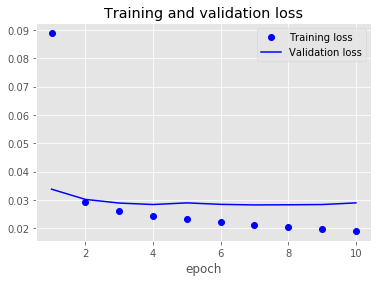

In [107]:
# run this cell to show your results #
plot_training_history(history)

**2.3b** Visualize outputs from the SimpleRNN layer, one subplot for B-tags and one subplot for I-tags. Comment on the patterns you observed.

In [47]:
# your code here
RNN = load_keras_model("model_RNN")

def create_truncated_model_RNN(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(SimpleRNN(n_units, return_sequences=True))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

truncated_model = create_truncated_model_RNN(RNN)
hidden_features = truncated_model.predict(x_test)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.8732458514450903


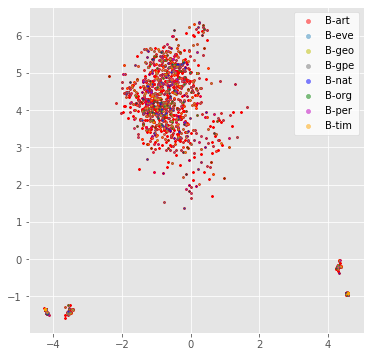

In [109]:
visualize_hidden_features(pca_result)

Variance explained by PCA: 0.8731334656664116


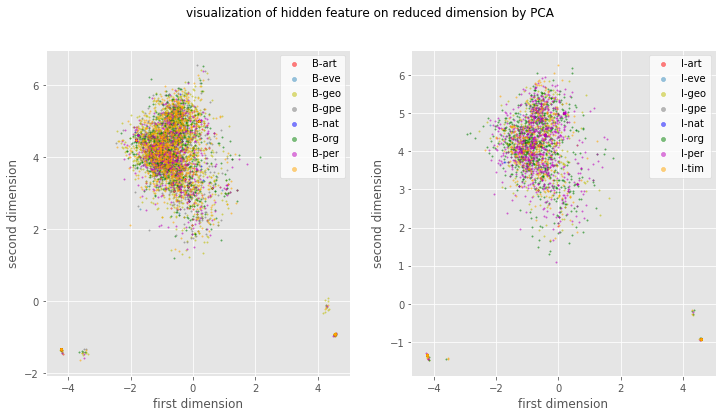

In [65]:
h = get_hidden_output_PCA(RNN,x_test,y_test,2,50)  # RNN layer idx = 2
visualize_B_I(h)

It seems that most part of the data points are still mixed together, 4 small clusters fall outside of the main cluster. In general, the pca plot in 2D doesn't show the data points are separable in 2D.

<div class='explication'> </div>

**2.4** **Model 4: GRU**

**2.4a** Briefly explain what a GRU is and how it's different from a simple RNN.

*your answer here*

GRU is gated recurrent units, which uses gates to regulate what information should be carried to the next iteration. Due to the vanishing gradient problem, simple RNN has only short memories of information. GRU can learn which data in a sequence is important to keep or throw away.

**2.4b** Define, compile, and train a GRU architecture by replacing the SimpleRNN cell with a GRU one. Use the provided code to save the model and plot the training history.

In [48]:
# your code here
model=Sequential()

model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(GRU(n_units, return_sequences=True))  #return_sequences=True will take care of the shape issues
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))   # dense layer has to add activation, otherwise accuracy

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_3 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________


In [112]:
# train model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                   validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 41s 1ms/sample - loss: 0.0873 - accuracy: 0.9784 - val_loss: 0.0335 - val_accuracy: 0.9903
Epoch 2/10
38847/38847 [==============================] - 36s 928us/sample - loss: 0.0289 - accuracy: 0.9915 - val_loss: 0.0299 - val_accuracy: 0.9912
Epoch 3/10
38847/38847 [==============================] - 36s 922us/sample - loss: 0.0257 - accuracy: 0.9924 - val_loss: 0.0283 - val_accuracy: 0.9916
Epoch 4/10
38847/38847 [==============================] - 36s 929us/sample - loss: 0.0240 - accuracy: 0.9929 - val_loss: 0.0277 - val_accuracy: 0.9918
Epoch 5/10
38847/38847 [==============================] - 36s 926us/sample - loss: 0.0228 - accuracy: 0.9932 - val_loss: 0.0277 - val_accuracy: 0.9917
Epoch 6/10
38847/38847 [==============================] - 36s 922us/sample - loss: 0.0219 - accuracy: 0.9935 - val_loss: 0.0273 - val_accuracy: 0.9919
Epoch 7/10
38847/38847 [=======================

In [113]:
# save your model #
store_keras_model(model, 'model_GRU')

Saved model to disk


In [114]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_8 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru (GRU)                    (None, 104, 100)          45600     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,368
Trainable params: 1,806,368
Non-trainable params: 0
_________________________________________________________________
None


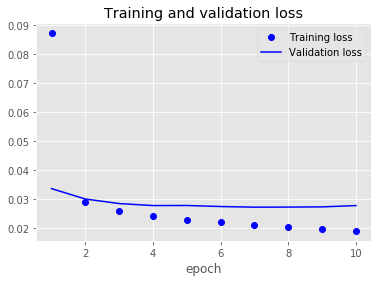

In [115]:
# run this cell to show your results #
plot_training_history(history)

**2.4c** Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

In [49]:
# your code here
model_GRU = load_keras_model("model_GRU")  # here don't call the model GRU since the layer is also GRU

def create_truncated_model_GRU(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(GRU(n_units, return_sequences=True))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

truncated_model = create_truncated_model_GRU(model_GRU)
hidden_features = truncated_model.predict(x_test)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.8385456382139522


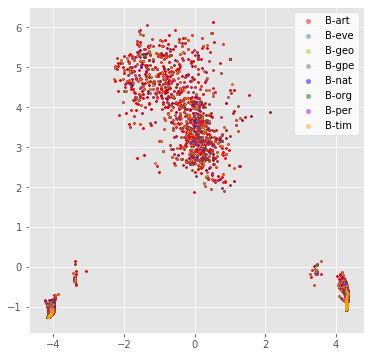

In [50]:
visualize_hidden_features(pca_result)

Variance explained by PCA: 0.838545477675631


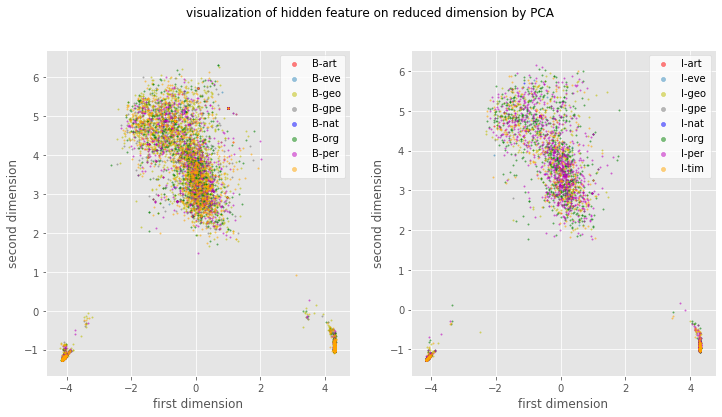

In [66]:
h = get_hidden_output_PCA(model_GRU,x_test,y_test,2,50)
visualize_B_I(h)

*your answer here*

Not much different from the previous RNN model, the data points form a big unseparable cluster and 4 small clusters outside. In general, all the points are mixed together in the 2D plot. The pattern recognized by the deep NN is not recognizable on 2D.

**2.5** **Model 5: Bidirectional GRU**

**2.5a** Explain how a Bidirectional GRU differs from GRU model above.



*your answer here*

Compared to GRU, bidirectional GRU allows for the use of information from both previous time steps and later time steps to make predictions about the current state, which can also be interpreted as the sentences are 'read' in both directions.

**2.5b** Define, compile, and train a bidirectional GRU by wrapping your GRU layer in a Bidirectional one. Use the provided code to save the model and plot the training history.


In [53]:
# your code here
model=Sequential()

model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(n_units, return_sequences=True)))  # bidirectional needs to be initialized with a layer instance
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))   # dense layer has to add activation, otherwise accuracy

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_6 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________


In [54]:
# train model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                   validation_split=validation_split, verbose=verbose)

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 72s 2ms/sample - loss: 0.0717 - accuracy: 0.9819 - val_loss: 0.0284 - val_accuracy: 0.9917
Epoch 2/10
38847/38847 [==============================] - 67s 2ms/sample - loss: 0.0240 - accuracy: 0.9930 - val_loss: 0.0251 - val_accuracy: 0.9926
Epoch 3/10
38847/38847 [==============================] - 67s 2ms/sample - loss: 0.0206 - accuracy: 0.9939 - val_loss: 0.0237 - val_accuracy: 0.9930
Epoch 4/10
38847/38847 [==============================] - 67s 2ms/sample - loss: 0.0188 - accuracy: 0.9944 - val_loss: 0.0234 - val_accuracy: 0.9931
Epoch 5/10
38847/38847 [==============================] - 67s 2ms/sample - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.0235 - val_accuracy: 0.9930
Epoch 6/10
38847/38847 [==============================] - 67s 2ms/sample - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.0233 - val_accuracy: 0.9931
Epoch 7/10
38847/38847 [==============================] -

In [55]:
# save your model #
store_keras_model(model, 'model_BiGRU')

Saved model to disk


In [56]:
# run this cell to show your results #
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_6 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________
None


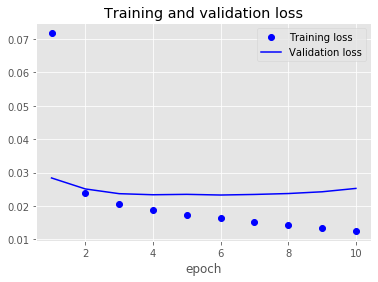

In [57]:
# run this cell to show your results #
plot_training_history(history)

**2.5c** Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**. Comment on the patterns you observed.

In [60]:
# your code here
BiGRU = load_keras_model("model_BiGRU")  # here don't call the model GRU since the layer is also GRU

def create_truncated_model_BiGRU(trained_model):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(tf.keras.layers.Dropout(drop_rate))
    model.add(Bidirectional(GRU(n_units, return_sequences=True)))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

truncated_model = create_truncated_model_BiGRU(BiGRU)
hidden_features = truncated_model.predict(x_train)

# flatten data
hidden_features = hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.5806336596002617


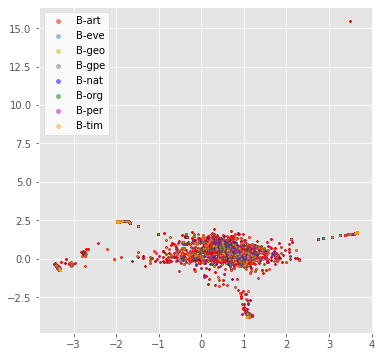

In [61]:
visualize_hidden_features(pca_result)

Variance explained by PCA: 0.5672625987994235


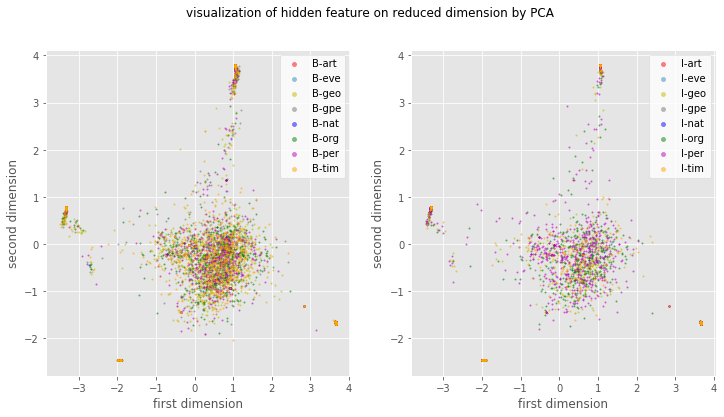

In [69]:
h = get_hidden_output_PCA(BiGRU,x_test,y_test,2,50)
visualize_B_I(h)

*your answer here*

The shape of the clusters is slightly different, but in general, the data points fall into a main cluster and four outter small clusters. All tags are mixed together. The outter clusters have slightly more concentrated with certain tags.

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

**3.3** Briefly discuss the performance of each model


**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.


## Answers

**3.1** For each model, iteratively:

- Load the model using the given function ```load_keras_model```

- Apply the model to the test dataset

- Compute an F1 score for each ```Tag``` and store it 

In [131]:
y_pred_baseline=baseline[x_test].flatten()
f1_base=f1_score(y_test_tag, y_pred_baseline, labels=range(18), average=None)
print(f1_base)

array([[16, 16, 16, ..., 17, 17, 17],
       [ 3, 16, 16, ..., 17, 17, 17],
       [16, 16,  7, ..., 17, 17, 17],
       ...,
       [ 6, 14, 16, ..., 17, 17, 17],
       [ 2, 16, 16, ..., 17, 17, 17],
       [16, 16, 16, ..., 17, 17, 17]])

In [132]:
# your code here

# baseline
y_pred_baseline=baseline[x_test].flatten()
y_test_tag=y_test.argmax(axis=2).flatten()
f1_base=f1_score(y_test_tag, y_pred_baseline, labels=range(18), average=None)
print(f1_base)

# FFNN
FFNN = load_keras_model("model_FFNN")
y_pred_FFNN=FFNN.predict(x_test).argmax(axis=2).flatten()  # y_pred (,104,18), 
# y_test_tag=y_test.argmax(axis=2).flatten()
f1_FFNN=f1_score(y_test_tag, y_pred_FFNN, labels=range(18),average=None)
print(f1_FFNN)

# RNN
RNN = load_keras_model("model_RNN")
y_pred_RNN=RNN.predict(x_test).argmax(axis=2).flatten()  # y_pred (,104,18), 
f1_RNN=f1_score(y_test_tag, y_pred_RNN, labels=range(18),average=None)
print(f1_RNN)

# GRU
model_GRU = load_keras_model("model_GRU")
y_pred_GRU=model_GRU.predict(x_test).argmax(axis=2).flatten()  # y_pred (,104,18), 
f1_GRU=f1_score(y_test_tag, y_pred_GRU, labels=range(18),average=None)
print(f1_GRU)

#BiGRU
BiGRU = load_keras_model("model_BiGRU")
y_pred_BiGRU=BiGRU.predict(x_test).argmax(axis=2).flatten()  # y_pred (,104,18), 
f1_BiGRU=f1_score(y_test_tag, y_pred_BiGRU, labels=range(18),average=None)
print(f1_BiGRU)

[0.01197007 0.39285714 0.80789674 0.93405929 0.16666667 0.57376058
 0.69250646 0.82487377 0.         0.11428571 0.6671565  0.36363636
 0.         0.61838836 0.67714011 0.26927785 0.98274761 1.        ]


/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.07692308 0.38461538 0.79657499 0.91561051 0.22222222 0.55822438
 0.68307485 0.80295567 0.         0.12903226 0.63836478 0.36363636
 0.         0.6002223  0.6677347  0.21727749 0.98093113 1.        ]
[0.04347826 0.42307692 0.83783431 0.92913867 0.46666667 0.62955747
 0.80150282 0.86450584 0.         0.21052632 0.78767123 0.4
 0.33333333 0.74473068 0.83886542 0.74219447 0.98781714 1.        ]
[0.04347826 0.39215686 0.83793422 0.93369997 0.5        0.64044944
 0.79777365 0.86928456 0.         0.31578947 0.7878369  0.4
 0.         0.74575205 0.84348865 0.76215278 0.98834926 1.        ]
[0.04166667 0.40677966 0.86652709 0.93984039 0.53333333 0.72414765
 0.8212766  0.90405336 0.         0.2        0.78854025 0.43478261
 0.33333333 0.76917945 0.84594993 0.79394449 0.9906196  1.        ]


**3.2** Plot the F1 score per Tag and per model making use of a grouped barplot.

In [165]:
idx2tag

{0: 'B-art',
 1: 'B-eve',
 2: 'B-geo',
 3: 'B-gpe',
 4: 'B-nat',
 5: 'B-org',
 6: 'B-per',
 7: 'B-tim',
 8: 'I-art',
 9: 'I-eve',
 10: 'I-geo',
 11: 'I-gpe',
 12: 'I-nat',
 13: 'I-org',
 14: 'I-per',
 15: 'I-tim',
 16: 'O',
 17: 'PAD'}

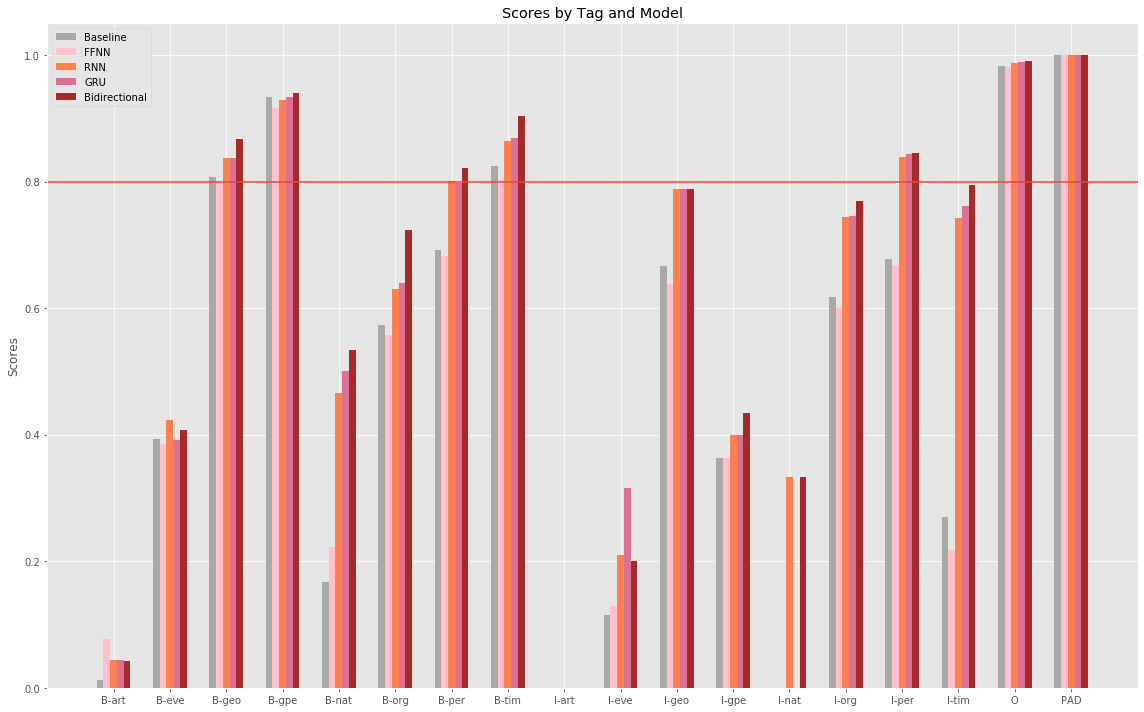

In [175]:
# your code here
ind = np.arange(18)  # the x locations for the groups
width = 0.12  # the width of the bars

fig, ax = plt.subplots(figsize=(16,10))
rects0 = ax.bar(ind - width*2, f1_base, width, label='Baseline', color='darkgrey')
rects1 = ax.bar(ind - width, f1_FFNN, width, label='FFNN', color='pink')
rects2 = ax.bar(ind, f1_RNN, width, label='RNN', color='coral')
rects3 = ax.bar(ind + width, f1_GRU, width, label='GRU', color='palevioletred')
rects5 = ax.bar(ind + width*2, f1_BiGRU, width, label='Bidirectional',color='brown')
ax.axhline(0.8)
ax.set_ylabel('Scores')
ax.set_title('Scores by Tag and Model')

# locs, labels=plt.xticks()
# plt.xticks(ind, tags)

ax.set_xticks(ind)
ax.set_xticklabels(tags)

ax.legend()

fig.tight_layout()

plt.show()

**3.3** Briefly discuss the performance of each model

*your answer here*


We can tell Bidirectional model generally outperforms all the rest models, and all the RNN models achieve much better performance than the FFNN model. For the RNN models, the performance rank is: Bidirectional > GRU > RNN.

The reason is that compared to simple feed-forward neural networks, RNN captures the sequence information of the input, and the GRU and Bidirectional models overcomes the problem of short memory of simple RNN, and weighs memories differently based on their importance.

**3.4** Which tags have the lowest f1 score? For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="data/B_art.png" alt="drawing" width="600"/>

*your answer here*

From the plot above, we can find that 'B-art', 'I-art' and 'I-eve' all have really low f1 scores. For 'I-nat', different models have quite different performances.

**3.5** Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [176]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [193]:
[idx2word[w] for w in x_test[rand, :15]]

['Many',
 'Democrats',
 'complained',
 'they',
 'were',
 'forced',
 'to',
 'approve',
 'the',
 'oil',
 'drilling',
 'provision',
 ',',
 'which',
 'they']

In [223]:
# find where y_test=='I-art' or 'B-art'
np.where(y_test_tag.reshape(-1,104)==8)  # return indices of rows and columns

(array([ 498,  498,  509,  744, 1036, 1158, 1398, 1398, 1401, 1401, 1401,
        1487, 1487, 2930, 2930, 3539, 4422, 4422, 4422, 4583, 4583, 4760,
        4760]),
 array([ 2,  3,  2, 28,  4,  9,  2,  3,  5,  6,  7,  5,  6, 23, 24, 27,  2,
         3,  4, 14, 15,  1,  2]))

In [228]:
# your code here
# select a sentence
rand = 1398   # or 498, 1036, 1158 also very good

# create a dictionary to hold the predictions
df={'Word':[idx2word[w] for w in x_test[rand, :15]], 
    'y_true':[idx2tag[t] for t in y_test_tag.reshape(-1,104)[rand, :15]],
   'baseline': [idx2tag[t] for t in y_pred_baseline.reshape(-1,104)[rand, :15]], 
    'model_FFNN':[idx2tag[t] for t in y_pred_FFNN.reshape(-1,104)[rand, :15]],
   'model_RNN':[idx2tag[t] for t in y_pred_RNN.reshape(-1, 104)[rand, :15]], 
    'model_GRU':[idx2tag[t] for t in y_pred_GRU.reshape(-1,104)[rand, :15]],
   'model_BiGRU':[idx2tag[t] for t in y_pred_BiGRU.reshape(-1, 104)[rand, :15]]
   }

df_err=pd.DataFrame(df)
df_err

,Word,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,The,O,O,O,O,O,O
1,Los,B-art,B-geo,B-geo,B-geo,B-geo,B-org
2,Angeles,I-art,I-geo,I-geo,I-geo,I-org,I-org
3,Times,I-art,I-org,I-org,I-org,I-org,I-org
4,reports,O,O,O,O,O,O
5,the,O,O,O,O,O,O
6,22-year-old,O,O,O,O,O,O
7,pop-rock,O,B-art,O,O,O,O
8,singer,O,O,O,O,O,O
9,and,O,O,O,O,O,O


In [231]:
# your code here
df_err.style.apply(highlight_errors, axis=1)  # apply style to a dataframe

,Word,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,The,O,O,O,O,O,O
1,Los,B-art,B-geo,B-geo,B-geo,B-geo,B-org
2,Angeles,I-art,I-geo,I-geo,I-geo,I-org,I-org
3,Times,I-art,I-org,I-org,I-org,I-org,I-org
4,reports,O,O,O,O,O,O
5,the,O,O,O,O,O,O
6,22-year-old,O,O,O,O,O,O
7,pop-rock,O,B-art,O,O,O,O
8,singer,O,O,O,O,O,O
9,and,O,O,O,O,O,O


In [ ]:
# your code here


**3.6** Choose one of the most promising models you have built, improve this model to achieve an f1 score higher than 0.8 for as many tags as possible (you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, etc.)

In [ ]:
# data augmentation


In [235]:
# your code here
# adding mask to the layers so that the model won't learn the 'PAD' tag
model=Sequential()

# mask value 17
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))  # adding mask_zero=True
model.add(tf.keras.layers.Masking(mask_value=17))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(n_units, return_sequences=True))) 
model.add(TimeDistributed(Dense(n_tags, activation='softmax')))  

model.compile(optimizer=optimizer, loss=loss, metrics=metrics, sample_weight_mode='temporal')  # upsample infrequent tags

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 104, 50)           1758950   
_________________________________________________________________
masking_1 (Masking)          (None, 104, 50)           0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 104, 50)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 104, 200)          91200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,768
Trainable params: 1,853,768
Non-trainable params: 0
_________________________________________________________________


In [236]:
# train model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                   validation_split=validation_split, verbose=verbose)

store_keras_model(model, 'model_augment')

Train on 38847 samples, validate on 4317 samples
Epoch 1/10
38847/38847 [==============================] - 75s 2ms/sample - loss: 0.0692 - accuracy: 0.9827 - val_loss: 0.0281 - val_accuracy: 0.9918
Epoch 2/10
38847/38847 [==============================] - 71s 2ms/sample - loss: 0.0234 - accuracy: 0.9931 - val_loss: 0.0251 - val_accuracy: 0.9925
Epoch 3/10
38847/38847 [==============================] - 71s 2ms/sample - loss: 0.0200 - accuracy: 0.9941 - val_loss: 0.0240 - val_accuracy: 0.9928
Epoch 4/10
38847/38847 [==============================] - 72s 2ms/sample - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.0237 - val_accuracy: 0.9930
Epoch 5/10
38847/38847 [==============================] - 72s 2ms/sample - loss: 0.0167 - accuracy: 0.9950 - val_loss: 0.0235 - val_accuracy: 0.9932
Epoch 6/10
38847/38847 [==============================] - 71s 2ms/sample - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0234 - val_accuracy: 0.9932
Epoch 7/10
38847/38847 [==============================] -

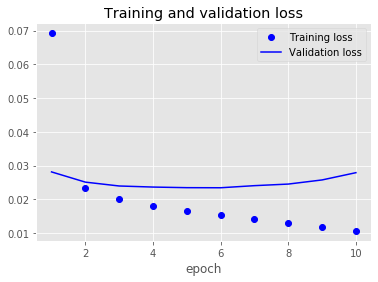

In [237]:
plot_training_history_training_history_training_history(history)

In [243]:
# calculate f1 score
model_aug = load_keras_model('model_augment')

y_pred_aug = model_aug.predict(x_test).argmax(axis=2).flatten()
f1_aug = f1_score(y_test_tag, y_pred_aug, labels=range(18),average=None)

/usr/share/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


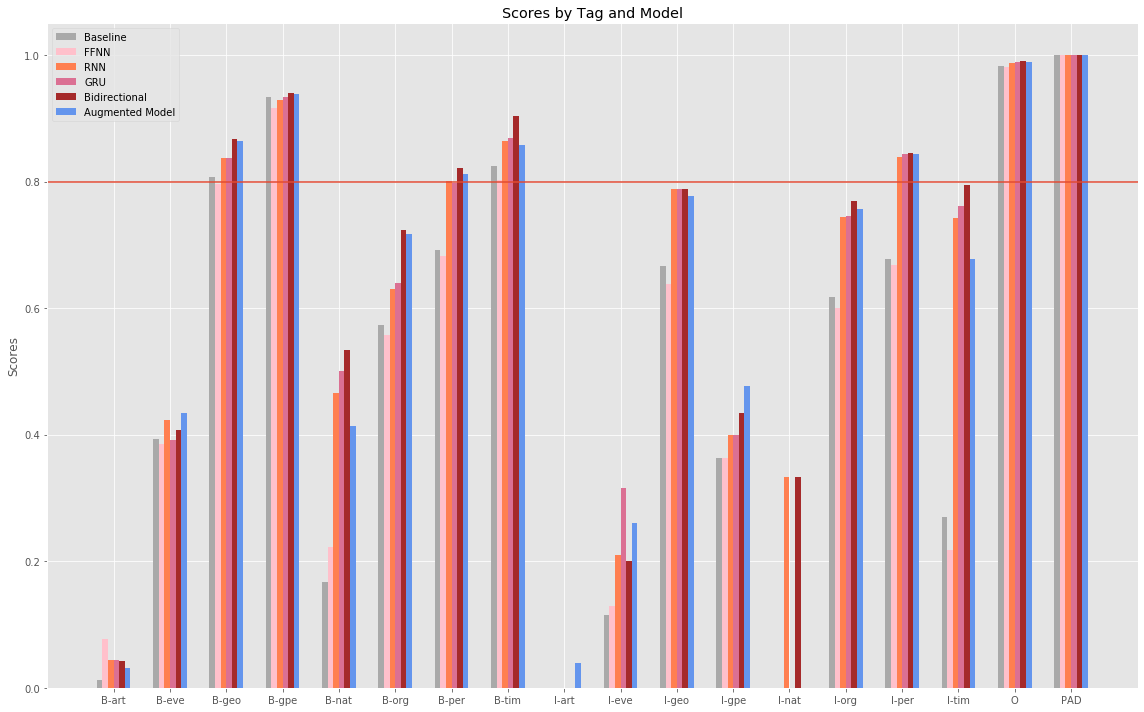

In [246]:
# plot f1
ind = np.arange(18)  # the x locations for the groups
width = 0.10  # the width of the bars

fig, ax = plt.subplots(figsize=(16,10))
rects0 = ax.bar(ind - width*2.5, f1_base, width, label='Baseline', color='darkgrey')
rects1 = ax.bar(ind - width*1.5, f1_FFNN, width, label='FFNN', color='pink')
rects2 = ax.bar(ind - width*0.5, f1_RNN, width, label='RNN', color='coral')
rects3 = ax.bar(ind + width*0.5, f1_GRU, width, label='GRU', color='palevioletred')
rects5 = ax.bar(ind + width*1.5, f1_BiGRU, width, label='Bidirectional',color='brown')

rects6 = ax.bar(ind + width*2.5, f1_aug, width, label='Augmented Model',color='cornflowerblue')

ax.axhline(0.8)
ax.set_ylabel('Scores')
ax.set_title('Scores by Tag and Model')

# locs, labels=plt.xticks()
# plt.xticks(ind, tags)

ax.set_xticks(ind)
ax.set_xticklabels(tags)

ax.legend()

fig.tight_layout()

plt.show()

**3.7** Explain why you chose to change certain elements of the model and how effective these adjustments were.

*your answer here*

I did two modifications to the original bidirectional model: 1. assigning different weight to different tags so that infrequent tags will be weighted more, and 2. using mask layer to mask 'PAD' tag since we don't want the model to learning weights for paddings.

from the results, it seems that it does improve on predicting 'I-art' tag a little bit but definitely not over 0.8. In general, the model doesn't improve much compared to the previous bidirectional model. My guess is that I didn't do right on the data augmentation part.